### In this file:

We will implement the R-CNN step by step, using the Airflow dataset from http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html

The source code is referenced at: https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [1]:
import os, cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split

2023-06-28 17:21:32.460285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 17:21:32.944723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check if tensorflow support GPU
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-06-28 17:21:34.513471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:21:34.513608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:21:34.549703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:21:34.549761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:21:34.549800: I tensorflow/compile

In [3]:
def calculate_iou(bb1, bb2):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Parameters:
    bb1 (tuple): A tuple of 4 integers representing the (x, y) coordinates of the top-left corner and the (width, height) of the first bounding box.
    bb2 (tuple): A tuple of 4 integers representing the (x, y) coordinates of the top-left corner and the (width, height) of the second bounding box.

    Returns:
    float: The IoU of the two bounding boxes.
    """
    # Calculate the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[0] + bb1[2], bb2[0] + bb2[2])
    y_bottom = min(bb1[1] + bb1[3], bb2[1] + bb2[3])

    # If the intersection is empty, return 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    bb1_area = bb1[2] * bb1[3]
    bb2_area = bb2[2] * bb2[3]

    # Calculate the IoU
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou

The images are in 'Data/Images'

The annotations are in 'Data/Annotations'

In [4]:
# Read filenames in the images folder
image_filenames = os.listdir('Data/Images/')
image_filenames = [filename for filename in image_filenames if filename[-4:] == '.jpg']

In [5]:
# Read the bounding boxes from the csv file
annotation_filenames = os.listdir('Data/Annotations/')
annotation_filenames = [filename for filename in annotation_filenames if filename[-4:] == '.csv']

In [6]:
# Make sure that the filenames are sorted in the same order
image_filenames.sort()
annotation_filenames.sort()

In [7]:
# Loop over the image filenames and make sure that there is a corresponding annotation file for it
for i in range(len(image_filenames)):
    assert image_filenames[i][:-4] == annotation_filenames[i][:-4], 'Filename mismatch!'

In [8]:
# Prepend the path to the filenames
image_filenames = ['Data/Images/' + filename for filename in image_filenames]
annotation_filenames = ['Data/Annotations/' + filename for filename in annotation_filenames]

In [9]:
# Create a dataframe to store the bounding boxes
def create_annotations(annotation_filenames):
    """
    Creates a list of annotations for each image based on the annotation files.
    
    Args:
        annotation_filenames (list): A list of annotation file paths.
        
    Returns:
        A list of dictionaries containing annotations for each image.
    """
    annotations = []
    
    for annotation_filename in annotation_filenames:
        with open(annotation_filename, "r") as f:
            # Read the number of boxes
            num_boxes = int(f.readline().strip())
            
            # Read the coordinates for each box
            boxes = []
            for i in range(num_boxes):
                x1, y1, x2, y2 = map(int, f.readline().strip().split())
                x = x1
                y = y1
                w = x2 - x1
                h = y2 - y1
                boxes.append([x, y, w, h])
            
            # Add the annotations for the current image
            annotations.append({"filename": annotation_filename[:-4] + ".jpg", "boxes": boxes})
    
    return annotations

In [10]:
# Create the annotations
annotations = create_annotations(annotation_filenames)

In [11]:
# Print the number of annotations
print('Number of annotations:', len(annotations))

Number of annotations: 733


In [12]:
# Check the first annotation for the first image
print(annotations[0])

{'filename': 'Data/Annotations/42845.jpg', 'boxes': [[15, 69, 25, 27], [10, 173, 32, 30], [74, 212, 26, 31], [233, 197, 23, 29]]}


### Let's load some random images and plot them with their annotations

In [13]:
# Build the image with the foreground regions
def build_image_with_regions(img, regions):
    # Loop over each region
    for x, y, w, h in regions:
        # Draw the bounding box on the image
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), thickness=1, lineType=cv2.LINE_AA)

    return img

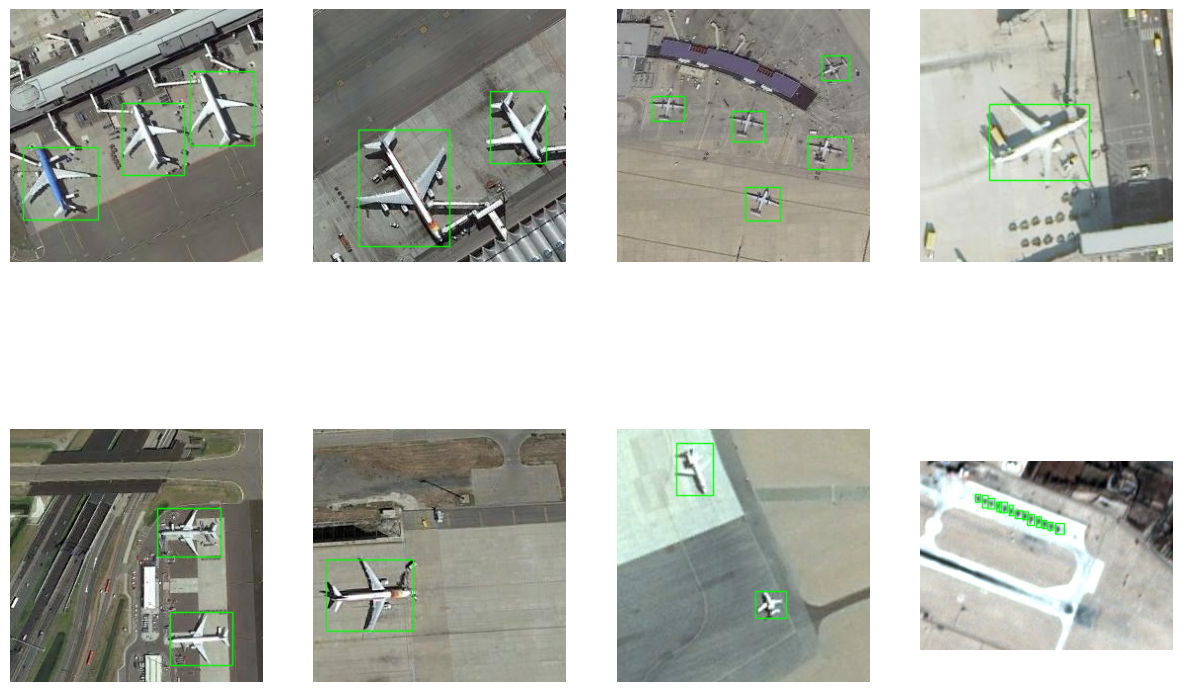

In [14]:
plt.figure(figsize=(15, 10))

# Let's plot 8 random images
for i in range(8):
    # Get a random index
    random_index = random.randint(0, len(image_filenames) - 1)
    
    # Read the image and draw a rectangle for each bounding box
    image = cv2.imread(annotations[random_index]['filename'].replace('Data/Annotations', 'Data/Images'))
    image = build_image_with_regions(image, annotations[random_index]['boxes'])
    
    # Plot the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### We need to learn how the proposed regions are generated, and how the CNN is trained to classify the regions.

In [15]:
# Load the first image
image = cv2.imread(image_filenames[0])

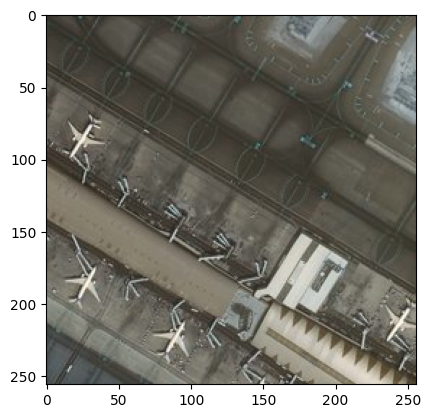

In [16]:
# Plot the image
plt.imshow(image)

In [17]:
# Initialize the selective search class
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [18]:
# Set the base image for selective search
ss.setBaseImage(image)

# Switch to fast selective search mode
ss.switchToSelectiveSearchFast()

# Run selective search on the image
rects = ss.process()

In [19]:
# Draw a rectangle around each proposed region
image_with_regions = build_image_with_regions(image.copy(), rects)

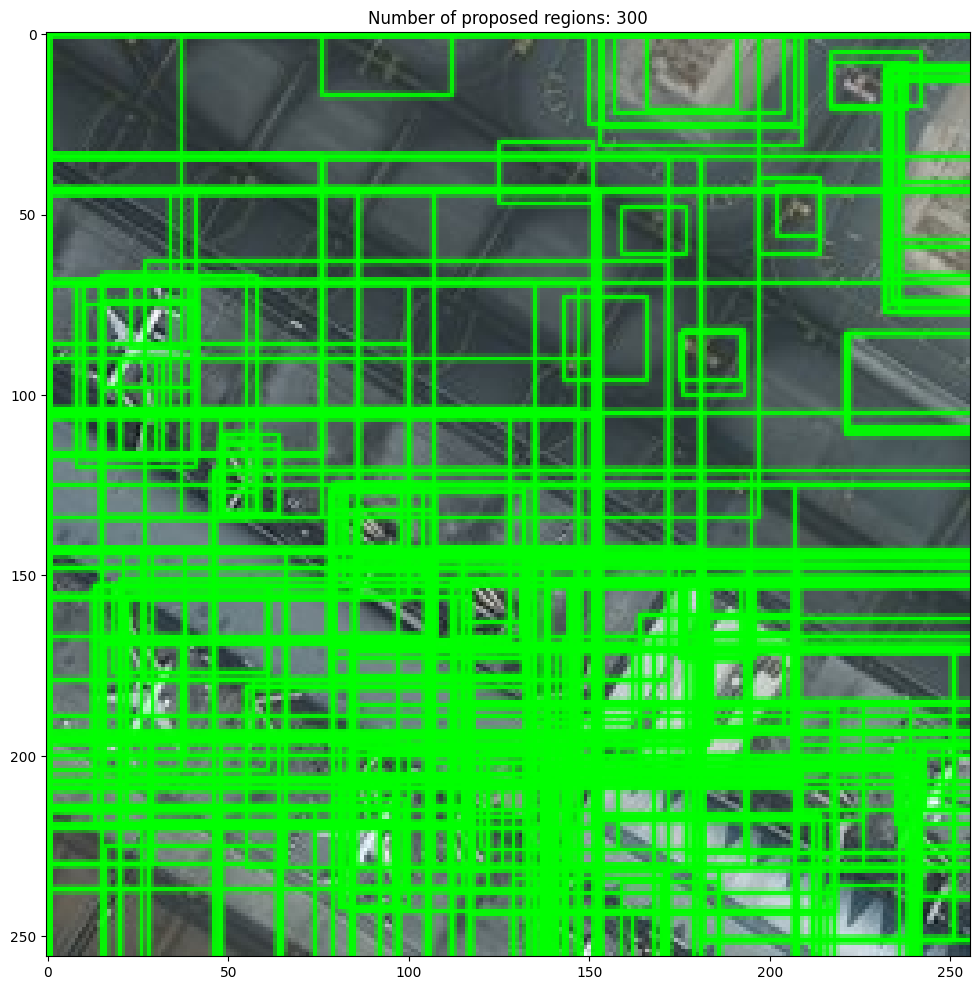

In [20]:
# Plot the image
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_with_regions, cv2.COLOR_BGR2RGB))

# Show how many proposed regions there are
plt.title('Number of proposed regions: {}'.format(len(rects)))

# Show
plt.show()

### Let's make a selective_search function

In [21]:
def selective_search(img):
    # Create a selective search object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # Set the input image for the selective search object
    ss.setBaseImage(img)

    # Set the search mode to fast but less accurate
    ss.switchToSelectiveSearchFast()

    # Perform selective search and return the proposed regions
    return ss.process()

### Create a training set

In [22]:
def create_training_data(images, annotations):
    """
    Creates a training dataset by selecting a maximum of 30 true and 30 false proposed regions for each image.
    
    Args:
        images (list): A list of image paths.
        annotations (list): A list of dictionaries containing annotations for each image.
        
    Returns:
        A tuple containing two lists:
        - A list of training images.
        - A list of training labels.
    """
    training_images = []
    training_labels = []
    
    for i, image_path in enumerate(images):
        # Load the image
        image = cv2.imread(image_path)
        
        # Get the annotations for the current image
        image_annotations = annotations[i]
        
        if len(image_annotations['boxes']) == 0:
            print(f'No boxes for {image_path}! Skipping...')
            continue      
        
        # Search for proposed regions in the image
        rects = selective_search(image)
        
        # Now we can convert color image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Only process the images with less than 2000 proposed regions
        if len(rects) > 2000:
            print(f'Too many proposed regions for {image_path}! Skipping...')
            continue  
        
        # Shuffle the proposed regions
        np.random.shuffle(rects)
        
        # Select a maximum of 30 true and 60 false proposed regions
        true_rects = []
        false_rects = []
        for rect in rects:
            if len(true_rects) == 30 and len(false_rects) == 30:
                break       
            
            iou = max([calculate_iou(rect, annotation) for annotation in image_annotations['boxes']])
            if iou >= 0.8 and len(true_rects) < 30:
                true_rects.append(rect)
                
                # Add the image to the training data with a label of 1
                x, y, w, h = rect
                roi = cv2.resize(image[y:y+h, x:x+w], (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_labels.append(1)
            elif iou < 0.2 and len(false_rects) < 30:
                false_rects.append(rect)
                
                # Add the image to the training data with a label of 0
                x, y, w, h = rect
                roi = cv2.resize(image[y:y+h, x:x+w], (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_labels.append(0)
                
        
        # Log the progress
        if i % 10 == 0:
            print(f'Processed {i} of {len(images)} images...')
    
    return training_images, training_labels

In [23]:
# Run the function to create the training data
training_images, training_labels = create_training_data(image_filenames, annotations)

Processed 0 of 733 images...
No boxes for Data/Images/428452.jpg! Skipping...
Processed 10 of 733 images...
No boxes for Data/Images/Lhasa.jpg! Skipping...
Too many proposed regions for Data/Images/Planes1.jpg! Skipping...
Too many proposed regions for Data/Images/Planes10.jpg! Skipping...
Too many proposed regions for Data/Images/Planes11.jpg! Skipping...
Too many proposed regions for Data/Images/Planes3.jpg! Skipping...
Too many proposed regions for Data/Images/Planes4.jpg! Skipping...
Too many proposed regions for Data/Images/Planes6.jpg! Skipping...
Too many proposed regions for Data/Images/Planes8.jpg! Skipping...
Processed 30 of 733 images...
Processed 40 of 733 images...
Processed 50 of 733 images...
Processed 60 of 733 images...
Processed 70 of 733 images...
Processed 80 of 733 images...
Processed 90 of 733 images...
Processed 100 of 733 images...
Processed 110 of 733 images...
Processed 120 of 733 images...
Processed 130 of 733 images...
Processed 140 of 733 images...
Processe

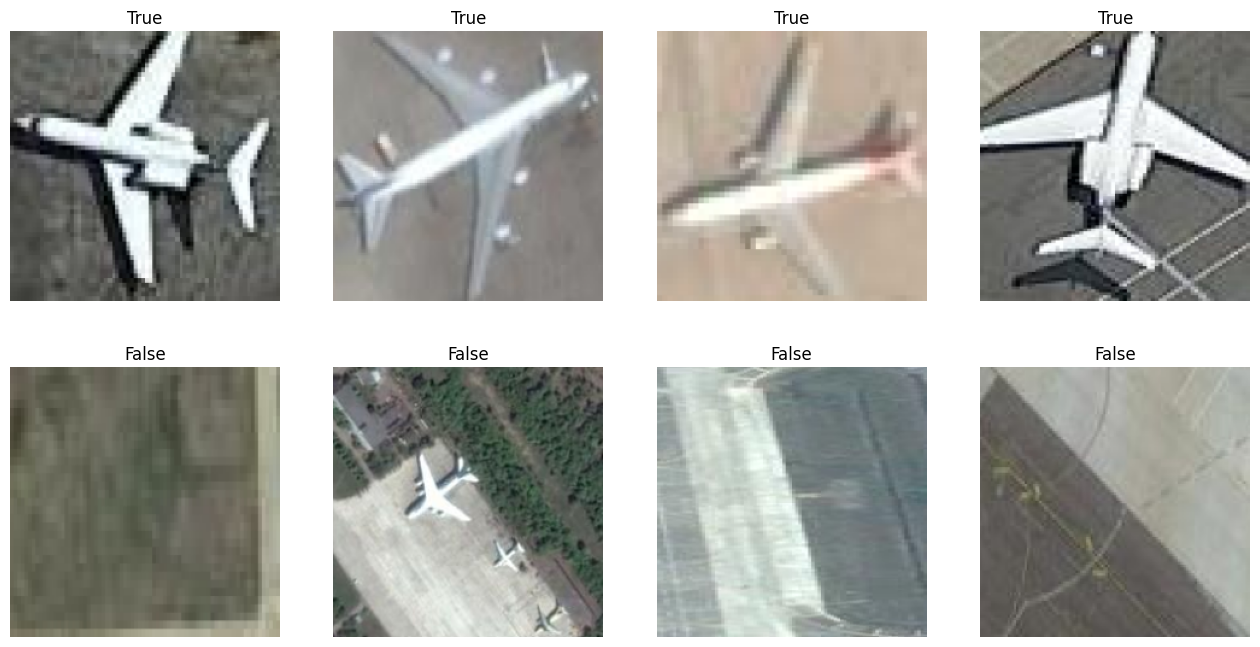

In [24]:
# Get the indices of the true and false labels
true_indices = [i for i, label in enumerate(training_labels) if label == 1]
false_indices = [i for i, label in enumerate(training_labels) if label == 0]

# Select 4 random images with true labels and 4 random images with false labels
true_indices_sample = random.sample(true_indices, 4)
false_indices_sample = random.sample(false_indices, 4)

# Plot the selected images
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, index in enumerate(true_indices_sample + false_indices_sample):
    img = training_images[index]
    label = training_labels[index]
    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].set_title("True" if label == 1 else "False")
    axs[i // 4, i % 4].axis("off")
plt.show()

In [25]:
# Convert the training images and labels to NumPy arrays
training_images = np.array(training_images)
training_labels = np.array(training_labels)

In [26]:
# Print the shape of the training images array and the training labels array
print(f'Training images shape: {training_images.shape}')
print(f'Training labels shape: {training_labels.shape}')

Training images shape: (25915, 224, 224, 3)
Training labels shape: (25915,)


In [27]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_images, training_labels, test_size=0.2, random_state=42)

In [28]:
# Type cast the training and validation labels to floats
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# Type cast the training and validation labels to floats
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [29]:
# Check the shape of the training and validation sets again
print(f'Training images shape: {X_train.shape}, dtype: {X_train.dtype}')
print(f'Training labels shape: {y_train.shape}, dtype: {y_train.dtype}')
print(f'Validation images shape: {X_val.shape}, dtype: {X_val.dtype}')
print(f'Validation labels shape: {y_val.shape}, dtype: {y_val.dtype}')

Training images shape: (20732, 224, 224, 3), dtype: float32
Training labels shape: (20732,), dtype: int32
Validation images shape: (5183, 224, 224, 3), dtype: float32
Validation labels shape: (5183,), dtype: int32


In [30]:
# Image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    preprocessing_function=preprocess_input
)
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create the training and validation generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
eval_generator = eval_datagen.flow(X_val, y_val, batch_size=32)

In [31]:
# We will use a VGG16 model pretrained on ImageNet and fine-tune it for our task
# Load the VGG16 model with ImageNet weights
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2023-06-28 17:25:16.090705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:25:16.090838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:25:16.090896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:25:16.090933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 17:25:16.090964: I tensorflow/compile

In [32]:
# Log the layers in the model if they are trainable or not
for layer in model.layers:
    print(f'{layer.name} is trainable: {layer.trainable}')

input_1 is trainable: True
block1_conv1 is trainable: True
block1_conv2 is trainable: True
block1_pool is trainable: True
block2_conv1 is trainable: True
block2_conv2 is trainable: True
block2_pool is trainable: True
block3_conv1 is trainable: True
block3_conv2 is trainable: True
block3_conv3 is trainable: True
block3_pool is trainable: True
block4_conv1 is trainable: True
block4_conv2 is trainable: True
block4_conv3 is trainable: True
block4_pool is trainable: True
block5_conv1 is trainable: True
block5_conv2 is trainable: True
block5_conv3 is trainable: True
block5_pool is trainable: True


In [33]:
# We will freeze the first 15 layers
for layer in model.layers[:15]:
    layer.trainable = False

In [34]:
# Attach a classification head
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model_final = tf.keras.models.Model(inputs=model.input, outputs=x)

In [35]:
# Compile the model
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

In [37]:
# Model summary
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
# Train the model
history = model_final.fit(train_generator, 
                          epochs=5, 
                          validation_data=eval_generator, 
                          callbacks=[early_stopping],
                          use_multiprocessing=True,
                          workers=8)

Epoch 1/5


2023-06-28 17:25:17.238834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-28 17:25:19.183240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-28 17:25:20.237574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-28 17:25:20.243126: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x53fa0720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-28 17:25:20.243162: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-28 17:25:20.243171: I

648/648 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9619

2023-06-28 17:25:48.981595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


648/648 [==============================] - 40s 56ms/step - loss: 0.1345 - accuracy: 0.9619 - val_loss: 0.0514 - val_accuracy: 0.9844
Epoch 2/5
648/648 [==============================] - 41s 62ms/step - loss: 0.0487 - accuracy: 0.9864 - val_loss: 0.0761 - val_accuracy: 0.9753
Epoch 3/5
648/648 [==============================] - 41s 62ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0262 - val_accuracy: 0.9898
Epoch 4/5
648/648 [==============================] - 42s 63ms/step - loss: 0.0302 - accuracy: 0.9909 - val_loss: 0.0398 - val_accuracy: 0.9886
Epoch 5/5
648/648 [==============================] - 39s 59ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0219 - val_accuracy: 0.9921


### We have trained a simple model. Let's find the objects in the test image.

In [39]:
def preprocess_image(img, target_size=(224, 224)):
    # Resize the input image to the target size
    img = cv2.resize(img, target_size)

    # Convert the image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Use the preprocess_input method of the VGG16 model
    img = preprocess_input(img)
    
    return img

In [76]:
def get_foreground_regions(img, model, batch_size=32, confidence_threshold=0.90):
    # Perform selective search on the input image
    proposed_regions = selective_search(img)

    # Initialize an empty list to store the foreground regions
    foreground_regions = []
    
    # Region scores
    region_scores = []

    # Initialize an empty list to store the region images
    region_images = []

    # Loop over each proposed region
    for region in proposed_regions:
        # Extract the region from the input image
        x, y, w, h = region
        
        # Crop the region from the input image
        region_img = img[y:y+h, x:x+w]

        # Preprocess the region image
        region_img = preprocess_image(region_img)

        # Add the region image to the list of region images
        region_images.append(region_img)

        # Check if the batch size has been reached
        if len(region_images) == batch_size:
            # Convert the list of region images to a numpy array
            region_images = np.array(region_images)

            # Pass the region images to the model for prediction
            scores = model.predict(region_images)

            # Loop over each score
            for i, score in enumerate(scores):
                # Check if the foreground class has a high probability score
                if score[1] > confidence_threshold:
                    # Add the corresponding region to the list of foreground regions
                    foreground_regions.append(proposed_regions[i])
                    # Add the corresponding score to the list of region scores
                    region_scores.append(score[1])

            # Clear the list of region images
            region_images = []

    # Check if there are any remaining region images
    if len(region_images) > 0:
        # Convert the list of region images to a numpy array
        region_images = np.array(region_images)

        # Pass the region images to the model for prediction
        scores = model.predict(region_images)

        # Loop over each score
        for i, score in enumerate(scores):
            # Check if the foreground class has a high probability score
            if score[1] > confidence_threshold:
                # Add the corresponding region to the list of foreground regions
                foreground_regions.append(proposed_regions[i])
                # Add the corresponding score to the list of region scores
                region_scores.append(score[1])

    # Convert the list of foreground regions to a numpy array
    foreground_regions = np.array(foreground_regions)
    
    # Convert the list of region scores to a numpy array
    region_scores = np.array(region_scores)

    return foreground_regions, region_scores

In [77]:
# Get the foreground regions
img = cv2.imread(image_filenames[200])
foreground_regions, region_scores = get_foreground_regions(img, model_final)

1/1 [==============================] - 0s 26ms/step


In [78]:
# Loop over each foreground region and draw a bounding box on the original image
image_with_regions = build_image_with_regions(img.copy(), foreground_regions)

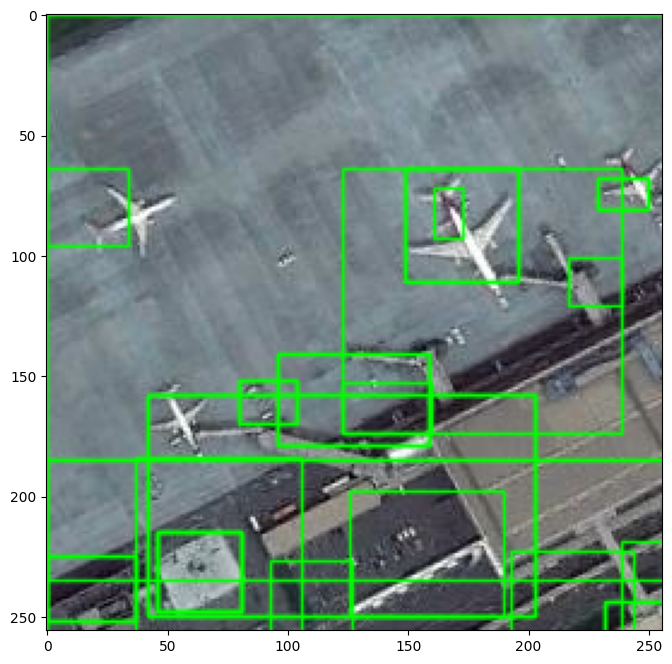

In [79]:
plt.figure(figsize=(12, 8))
plt.imshow(image_with_regions)

### The result contains too many overlapping boxes. We need to use Non-Maximum Suppression to remove the overlapping boxes.

In [80]:
def non_max_suppression(boxes, scores, overlap_threshold=0.5):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indices
    picked_indices = []

    # Sort the bounding boxes by their scores in descending order
    indices = np.argsort(scores)[::-1]

    # Loop over the indices
    while len(indices) > 0:
        # Grab the index of the largest score
        i = indices[0]

        # Add the index to the list of picked indices
        picked_indices.append(i)

        # Find the overlap between the current box and all other boxes
        # overlaps = calculate_iou(boxes[i], boxes[indices[1:]])
        overlaps = np.array([calculate_iou(boxes[i], boxes[j]) for j in indices[1:]])

        # Remove the indices of all boxes where the overlap is greater than the overlap threshold
        indices = indices[1:][overlaps <= overlap_threshold]

        # Check if there are any more boxes to process
        if len(indices) == 0:
            break

    # Return only the bounding boxes that were picked
    return boxes[picked_indices], scores[picked_indices]

In [81]:
# Use the non_max_suppression function to get the final bounding boxes
final_boxes, final_scores = non_max_suppression(foreground_regions, region_scores)

In [85]:
# Loop over each final bounding box and draw it on the original image
image_with_regions = build_image_with_regions(img.copy(), final_boxes)

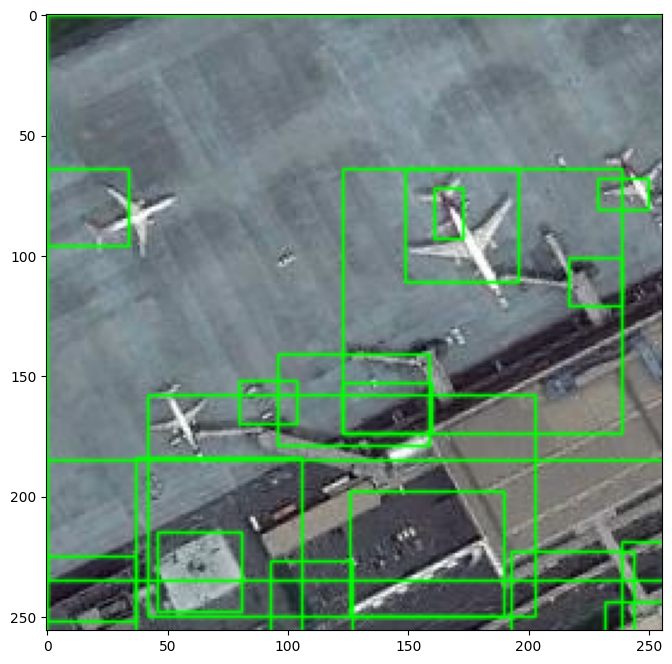

In [86]:
plt.figure(figsize=(12, 8))
plt.imshow(image_with_regions)